In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time
#import pytorch for building RNN model
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
#import scaler for normalization
from sklearn.preprocessing import MinMaxScaler

In [2]:
#define a function to split data into train and test sets
def split_data(stock, lookback):
    data_raw = stock # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback+1])
    data = np.array(data);
    
    #split into test and train
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]



In [74]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size, n_layers, drop_prob=0.2):
        super(RNN, self).__init__()
        
        #Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        #Defining layers
        #RNN, use dropout to avoid overfitting
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        #Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
        #activation function, using RELU to prevent shrinking the gradient
        self.relu = nn.ReLU()
    
    def forward(self, x, h):
        out, h = self.rnn(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self,batch_size):
        #generates the first hidden state of zeros used in the forward pass
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()
        return hidden
    
def train(train_loader, test_loader, learn_rate, hidden_dim=64, EPOCHS=20, model_type="RNN", loss_func="mse"):
    # Setting common hyperparameters
    input_dim = 1
    output_dim = 1
    n_layers = 1
    
    # Instantiating the models
    model = RNN(input_dim, hidden_dim, output_dim, n_layers)
    
    # Defining loss function and optimizer
    train_loss = []
    test_loss = []
    if (loss_func == "l1"):
        criterion = nn.L1Loss()
    else:
        criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.perf_counter()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        for x, label in train_loader:
            h = h.data
            model.zero_grad()
            
            out, h = model.forward(x.float(), h)
            loss = criterion(out, label.float())
            loss.backward()
            
            optimizer.step()
            avg_loss += loss.item()
    
        length = len(train_loader)
        avg_loss /= length
        train_loss.append(avg_loss)
        print("Epoch {}/{} Done, Total Training Loss: {}".format(epoch, EPOCHS, avg_loss))
        
        predictions = []
        values = []
        
        h = model.init_hidden(1)
        
        #define loss function criterion
        if(loss_func == "l1"):
            criterion = nn.L1Loss()
        else:
            #default
            criterion = nn.MSELoss()
        
        for x, label in test_loader:
            length = len(test_loader)
            avg_loss2 = 0.
            h = h.data
            model.zero_grad()
            
            out, h = model.forward(x.float(), h)
            loss2 = criterion(out, label.float()).item()
            avg_loss2 += loss2
            
            
            predictions.append(out.detach().numpy().reshape(-1))
            values.append(label.numpy().reshape(-1))
            
        test_loss.append(avg_loss2)
        print("Total Testing MSELoss: {}".format(avg_loss2))
        
        current_time = time.perf_counter()
        epoch_times.append(current_time-start_time)
        print("Total Time Elapsed: {} seconds".format(str(current_time-start_time)))
        print()
    
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model, train_loss, test_loss, predictions, values

def evaluate(model, test_loader, loss_func="mse"):
    with torch.no_grad():
        predictions = []
        values = []
        test_loss = []
        h = model.init_hidden(1)
        if(loss_func == "l1"):
            criterion = nn.L1Loss()
        else:
            criterion = nn.MSELoss()
        for x, label in test_loader:
            h = h.data
            model.zero_grad()
            #print(x.float().shape,h.shape)
            #print(x.float(),h)
            out, h = model.forward(x.float(), h)
            loss = criterion(out, label.float())
            loss = loss.item()
            loss_arr.append(loss)
            predictions.append(out.numpy().reshape(-1))
            values.append(label.numpy().reshape(-1))

    return predictions, values, loss, loss_arr

In [4]:
#data source path
dataset_folder = "../../dataset/"

# Microsoft

In [5]:
#load data
microsoft_df = pd.read_csv(dataset_folder + "microsoft.csv")

In [6]:
#use the close prices for analysis
microsoft_df['Date'] = pd.to_datetime(microsoft_df['Date'])
microsoft_df.set_index('Date',inplace=True)
microsoft_df.drop(columns=['Open','High','Low','Volume'],inplace=True)
microsoft_df

,Close
Date,
2015-04-01 16:00:00,40.72
2015-04-02 16:00:00,40.29
2015-04-06 16:00:00,41.55
2015-04-07 16:00:00,41.53
2015-04-08 16:00:00,41.42
...,...
2021-03-25 16:00:00,232.34
2021-03-26 16:00:00,236.48
2021-03-29 16:00:00,235.24


In [7]:
#normalize the data to the range 0-1
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(microsoft_df.values.reshape(-1,1))
scaled

array([[0.00210064],
       [0.        ],
       [0.00615535],
       ...,
       [0.95236932],
       [0.9358085 ],
       [0.95495848]])

In [8]:
#split the data
lookback = 5 # choose sequence length
train_x,train_y,test_x,test_y = split_data(scaled, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (1205, 5, 1)
y_train.shape:  (1205, 1)
X_test.shape:  (301, 5, 1)
y_test.shape:  (301, 1)


In [9]:
#prepare the data to make it suitable for putting into the model
#organize data into batches to make the backpropogation easier
batch_size = 32
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

### (1) Running the model with MSE loss

In [10]:
lr = 0.001
rnn_micro, micro_train_mse, micro_test_mse, predictions, values = train(train_loader, test_loader, lr, model_type="RNN", loss_func="mse")

Starting Training of RNN model


C:\Users\goodu\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/20 Done, Total Training Loss: 0.0024259741885298107
Total Testing MSELoss: 0.16772887110710144
Total Time Elapsed: 0.2868575 seconds

Epoch 2/20 Done, Total Training Loss: 0.043994838406089566
Total Testing MSELoss: 0.3362751305103302
Total Time Elapsed: 0.18008890000000033 seconds

Epoch 3/20 Done, Total Training Loss: 0.026599311841769
Total Testing MSELoss: 0.29628995060920715
Total Time Elapsed: 0.1917234999999997 seconds

Epoch 4/20 Done, Total Training Loss: 0.020328986071895948
Total Testing MSELoss: 0.24478814005851746
Total Time Elapsed: 0.1647483000000003 seconds

Epoch 5/20 Done, Total Training Loss: 0.013737596924526058
Total Testing MSELoss: 0.11934743076562881
Total Time Elapsed: 0.16252530000000043 seconds

Epoch 6/20 Done, Total Training Loss: 0.008711488982720079
Total Testing MSELoss: 0.020885147154331207
Total Time Elapsed: 0.17077909999999985 seconds

Epoch 7/20 Done, Total Training Loss: 0.0029629001681412874
Total Testing MSELoss: 0.023003222420811653
Tota

In [78]:
np.array(predictions).shape

(1460, 1)

In [79]:
np.array(values).shape


(1460, 1)

In [11]:
loss_df = pd.DataFrame(micro_train_mse, columns = ["micro_train_mse"])
loss_df['micro_test_mse'] = micro_test_mse
loss_df

,micro_train_mse,micro_test_mse
0,0.002426,0.167729
1,0.043995,0.336275
2,0.026599,0.296290
3,0.020329,0.244788
4,0.013738,0.119347
5,0.008711,0.020885
6,0.002963,0.023003
7,0.000601,0.017921
8,0.000788,0.005088
9,0.000325,0.022094


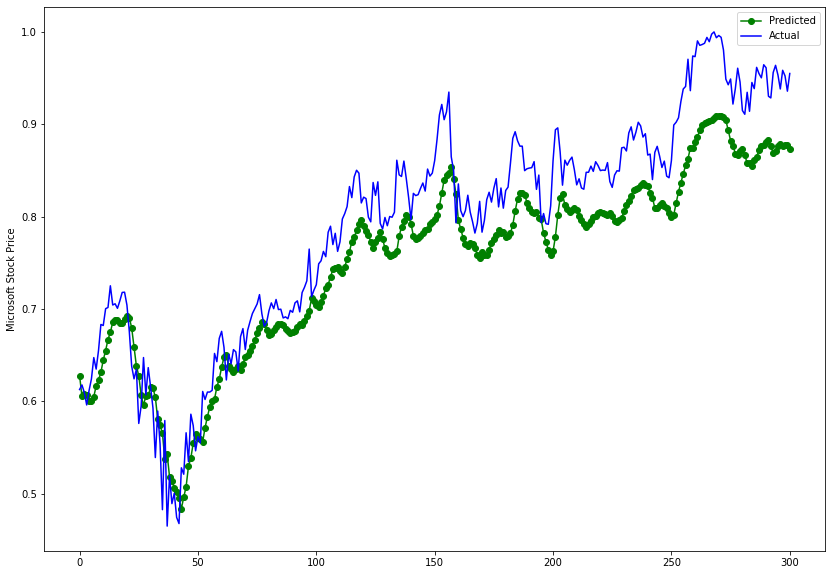

In [12]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Microsoft Stock Price')
plt.legend()

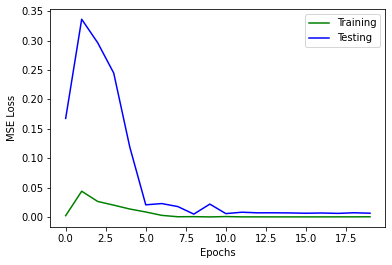

In [13]:
plt.plot(micro_train_mse, color="g", label="Training")
plt.plot(micro_test_mse, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

### (2) Running the model with L1 loss

In [14]:
lr = 0.001
rnn_micro2, micro_train_l1, micro_test_l1, predictions, values = train(train_loader, test_loader, lr, model_type="RNN", loss_func="l1")

C:\Users\goodu\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.03122785856091493
Total Testing MSELoss: 0.47542938590049744
Total Time Elapsed: 0.1938827999999999 seconds

Epoch 2/20 Done, Total Training Loss: 0.20071551087941672
Total Testing MSELoss: 0.6988645792007446
Total Time Elapsed: 0.17609459999999988 seconds

Epoch 3/20 Done, Total Training Loss: 0.11836145537578173
Total Testing MSELoss: 0.5996091961860657
Total Time Elapsed: 0.17576310000000017 seconds

Epoch 4/20 Done, Total Training Loss: 0.1497325043168825
Total Testing MSELoss: 0.6244993805885315
Total Time Elapsed: 0.1603432999999992 seconds

Epoch 5/20 Done, Total Training Loss: 0.09530651418341173
Total Testing MSELoss: 0.2803897261619568
Total Time Elapsed: 0.1650817999999994 seconds

Epoch 6/20 Done, Total Training Loss: 0.1889960192571822
Total Testing MSELoss: 0.48581868410110474
Total Time Elapsed: 0.17507370000000044 seconds

Epoch 7/20 Done, Total Training Loss: 0.12066779898580264
Total Testing MSELos

In [15]:
loss_df['micro_train_l1'] = micro_train_l1
loss_df['micro_test_l1'] = micro_test_l1
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1
0,0.002426,0.167729,0.031228,0.475429
1,0.043995,0.336275,0.200716,0.698865
2,0.026599,0.296290,0.118361,0.599609
3,0.020329,0.244788,0.149733,0.624499
4,0.013738,0.119347,0.095307,0.280390
5,0.008711,0.020885,0.188996,0.485819
6,0.002963,0.023003,0.120668,0.440419
7,0.000601,0.017921,0.072040,0.196013
8,0.000788,0.005088,0.060737,0.150038
9,0.000325,0.022094,0.045987,0.125508


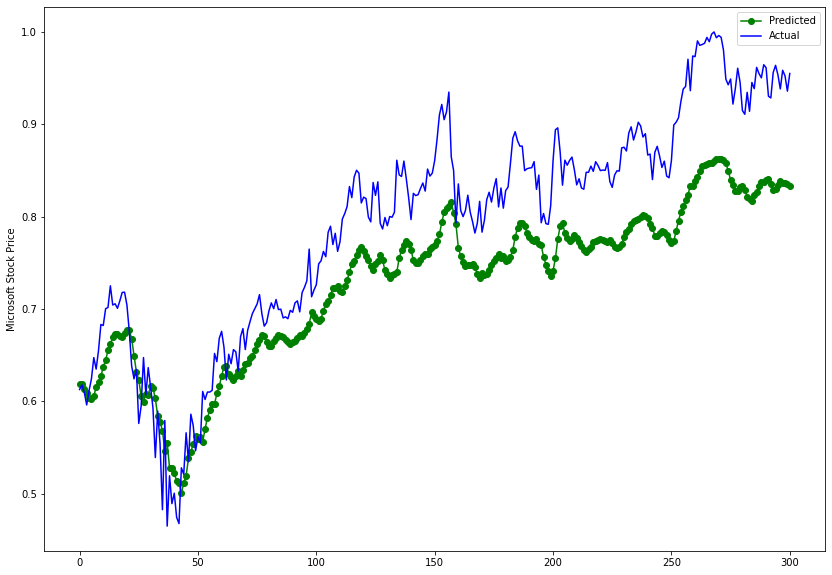

In [16]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Microsoft Stock Price')
plt.legend()

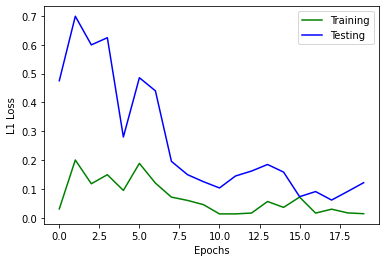

In [17]:
plt.plot(micro_train_l1, color="g", label="Training")
plt.plot(micro_test_l1, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()

## Artificial Data

In [18]:
art_data = pd.read_csv(dataset_folder +"Artificial_trend.csv")
art_data.set_index('date',inplace=True)
len(art_data)

7307

In [19]:
#normalize the data to the range 0-1
scaler = MinMaxScaler()
scaled_art1 = scaler.fit_transform(art_data.values.reshape(-1,1))
scaled_art1

array([[0.44861011],
       [0.44234504],
       [0.41956507],
       ...,
       [0.38776852],
       [0.4008299 ],
       [0.41748377]])

In [20]:
lookback = 5 # choose sequence length
train_x,train_y,test_x,test_y = split_data(scaled_art1, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (5842, 5, 1)
y_train.shape:  (5842, 1)
X_test.shape:  (1460, 5, 1)
y_test.shape:  (1460, 1)


In [21]:
batch_size = 64
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

### (1) Running the model with MSE loss

In [22]:
lr = 0.001
rnn_art1, art1_train_mse, art1_test_mse, predictions, values = train(train_loader, test_loader, lr, model_type="RNN")

Starting Training of RNN model


C:\Users\goodu\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/20 Done, Total Training Loss: 0.06684680524407528
Total Testing MSELoss: 0.004064636304974556
Total Time Elapsed: 0.6960496000000003 seconds

Epoch 2/20 Done, Total Training Loss: 0.032104102338492806
Total Testing MSELoss: 0.0024144824128597975
Total Time Elapsed: 0.6850588000000002 seconds

Epoch 3/20 Done, Total Training Loss: 0.030060732433352375
Total Testing MSELoss: 0.022900685667991638
Total Time Elapsed: 0.6874672000000004 seconds

Epoch 4/20 Done, Total Training Loss: 0.025088623570339693
Total Testing MSELoss: 0.014455609023571014
Total Time Elapsed: 0.7485254999999995 seconds

Epoch 5/20 Done, Total Training Loss: 0.01828983263432427
Total Testing MSELoss: 0.006389549467712641
Total Time Elapsed: 0.7329636999999991 seconds

Epoch 6/20 Done, Total Training Loss: 0.008903019155495913
Total Testing MSELoss: 0.004835296887904406
Total Time Elapsed: 0.8112051000000005 seconds

Epoch 7/20 Done, Total Training Loss: 0.0036004758104144666
Total Testing MSELoss: 3.6079225537

In [23]:
loss_df['art1_train_mse'] = art1_train_mse
loss_df['art1_test_mse'] = art1_test_mse
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1,art1_train_mse,art1_test_mse
0,0.002426,0.167729,0.031228,0.475429,0.066847,0.004065
1,0.043995,0.336275,0.200716,0.698865,0.032104,0.002414
2,0.026599,0.296290,0.118361,0.599609,0.030061,0.022901
3,0.020329,0.244788,0.149733,0.624499,0.025089,0.014456
4,0.013738,0.119347,0.095307,0.280390,0.018290,0.006390
5,0.008711,0.020885,0.188996,0.485819,0.008903,0.004835
6,0.002963,0.023003,0.120668,0.440419,0.003600,0.000036
7,0.000601,0.017921,0.072040,0.196013,0.001231,0.000092
8,0.000788,0.005088,0.060737,0.150038,0.000901,0.000163
9,0.000325,0.022094,0.045987,0.125508,0.000673,0.000264


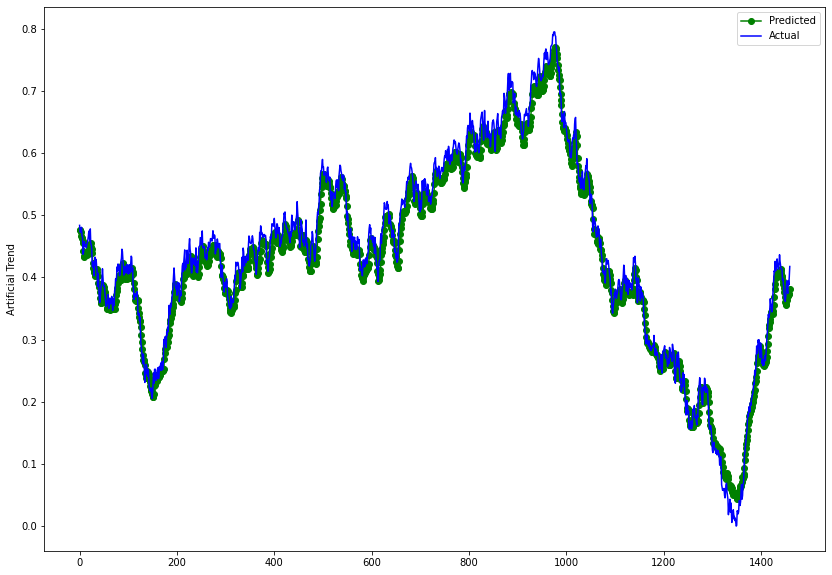

In [24]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Artificial Trend')
plt.legend()

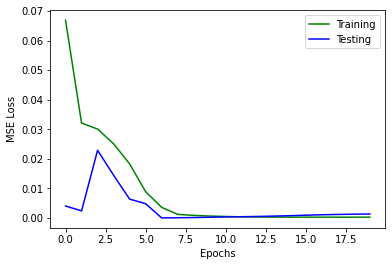

In [25]:
plt.plot(art1_train_mse, color="g", label="Training")
plt.plot(art1_test_mse, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

### (2) Running the model with L1 loss

In [26]:
lr = 0.001
rnn_art1_l1, art1_train_l1, art1_test_l1, predictions, values = train(train_loader, test_loader, lr, model_type="RNN", loss_func="l1")

C:\Users\goodu\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.20369424069157013
Total Testing MSELoss: 0.15043631196022034
Total Time Elapsed: 0.7900288999999994 seconds

Epoch 2/20 Done, Total Training Loss: 0.14338093140459324
Total Testing MSELoss: 0.1372843086719513
Total Time Elapsed: 0.7235043999999995 seconds

Epoch 3/20 Done, Total Training Loss: 0.1284980026820859
Total Testing MSELoss: 0.10297432541847229
Total Time Elapsed: 0.7129939999999984 seconds

Epoch 4/20 Done, Total Training Loss: 0.10295961545473271
Total Testing MSELoss: 0.09573987126350403
Total Time Elapsed: 0.7355763999999994 seconds

Epoch 5/20 Done, Total Training Loss: 0.08190599283469575
Total Testing MSELoss: 0.05547419190406799
Total Time Elapsed: 0.8624170000000007 seconds

Epoch 6/20 Done, Total Training Loss: 0.0521004341419909
Total Testing MSELoss: 0.015769153833389282
Total Time Elapsed: 0.7527227999999972 seconds

Epoch 7/20 Done, Total Training Loss: 0.03387354930432943
Total Testing MSELo

In [27]:
loss_df['art1_train_l1'] = art1_train_l1
loss_df['art1_test_l1'] = art1_test_l1
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1,art1_train_mse,art1_test_mse,art1_train_l1,art1_test_l1
0,0.002426,0.167729,0.031228,0.475429,0.066847,0.004065,0.203694,0.150436
1,0.043995,0.336275,0.200716,0.698865,0.032104,0.002414,0.143381,0.137284
2,0.026599,0.296290,0.118361,0.599609,0.030061,0.022901,0.128498,0.102974
3,0.020329,0.244788,0.149733,0.624499,0.025089,0.014456,0.102960,0.095740
4,0.013738,0.119347,0.095307,0.280390,0.018290,0.006390,0.081906,0.055474
5,0.008711,0.020885,0.188996,0.485819,0.008903,0.004835,0.052100,0.015769
6,0.002963,0.023003,0.120668,0.440419,0.003600,0.000036,0.033874,0.048768
7,0.000601,0.017921,0.072040,0.196013,0.001231,0.000092,0.030018,0.056063
8,0.000788,0.005088,0.060737,0.150038,0.000901,0.000163,0.029079,0.050303
9,0.000325,0.022094,0.045987,0.125508,0.000673,0.000264,0.026320,0.046991


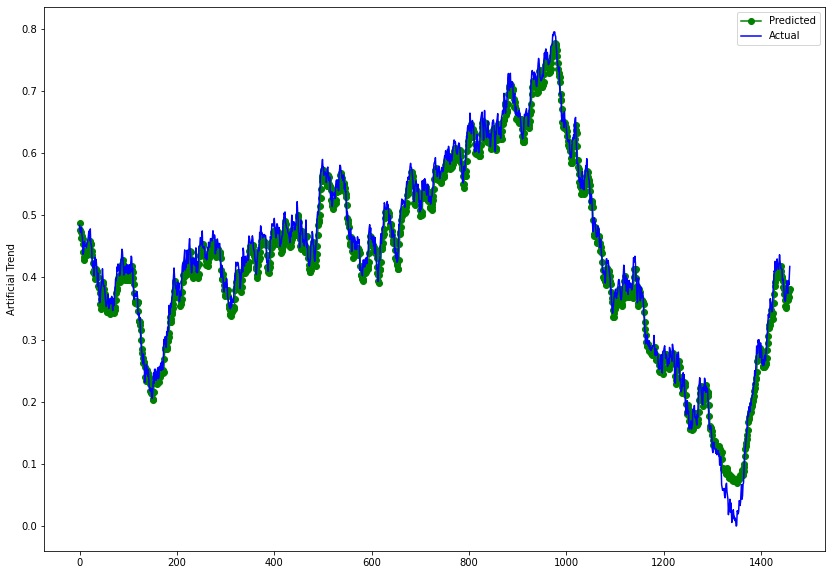

In [28]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Artificial Trend')
plt.legend()

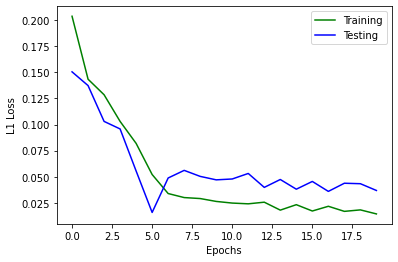

In [29]:
plt.plot(art1_train_l1, color="g", label="Training")
plt.plot(art1_test_l1, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()

## Crude Oil

In [30]:
oil_data = pd.read_csv(dataset_folder +"oil.csv")
oil_data['DATE'] = pd.to_datetime(oil_data['DATE'])
oil_data.set_index('DATE',inplace=True)
len(oil_data)

1566

In [31]:
oil_data[oil_data['DCOILBRENTEU'] == "."] = np.NaN
oil_data.dropna(inplace=True)
oil_data['DCOILBRENTEU'] = oil_data['DCOILBRENTEU'].astype("float")
oil_data

,DCOILBRENTEU
DATE,
2015-11-02,47.91
2015-11-03,48.00
2015-11-04,46.96
2015-11-05,47.19
2015-11-06,46.09
...,...
2021-10-26,85.11
2021-10-27,84.12
2021-10-28,83.40


In [32]:
#scaling the oil data
scaler = MinMaxScaler()
scaled_oil = scaler.fit_transform(oil_data.values)

train_x,train_y,test_x,test_y = split_data(scaled_oil, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (1219, 5, 1)
y_train.shape:  (1219, 1)
X_test.shape:  (305, 5, 1)
y_test.shape:  (305, 1)


In [33]:
batch_size = 32
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

### (1) Running the model with MSE loss

In [34]:
lr = 0.001
rnn_oil, oil_train_mse, oil_test_mse, predictions, values = train(train_loader, test_loader, lr, model_type="RNN")

Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.04316704365804693


C:\Users\goodu\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Total Testing MSELoss: 0.26444870233535767
Total Time Elapsed: 0.16704069999999405 seconds

Epoch 2/20 Done, Total Training Loss: 0.028633405665076633
Total Testing MSELoss: 0.25910595059394836
Total Time Elapsed: 0.1666973000000027 seconds

Epoch 3/20 Done, Total Training Loss: 0.04055516954854523
Total Testing MSELoss: 0.14239510893821716
Total Time Elapsed: 0.16303770000000384 seconds

Epoch 4/20 Done, Total Training Loss: 0.04487988783205908
Total Testing MSELoss: 0.13686683773994446
Total Time Elapsed: 0.16242180000000417 seconds

Epoch 5/20 Done, Total Training Loss: 0.02718211202208247
Total Testing MSELoss: 0.21524067223072052
Total Time Elapsed: 0.16542749999999984 seconds

Epoch 6/20 Done, Total Training Loss: 0.03308175346127858
Total Testing MSELoss: 0.11144517362117767
Total Time Elapsed: 0.16827260000000166 seconds

Epoch 7/20 Done, Total Training Loss: 0.04124622655523892
Total Testing MSELoss: 0.059384677559137344
Total Time Elapsed: 0.17861650000000395 seconds

Epoch 8

In [35]:
loss_df['oil_train_mse'] = oil_train_mse
loss_df['oil_test_mse'] = oil_test_mse
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1,art1_train_mse,art1_test_mse,art1_train_l1,art1_test_l1,oil_train_mse,oil_test_mse
0,0.002426,0.167729,0.031228,0.475429,0.066847,0.004065,0.203694,0.150436,0.043167,0.264449
1,0.043995,0.336275,0.200716,0.698865,0.032104,0.002414,0.143381,0.137284,0.028633,0.259106
2,0.026599,0.296290,0.118361,0.599609,0.030061,0.022901,0.128498,0.102974,0.040555,0.142395
3,0.020329,0.244788,0.149733,0.624499,0.025089,0.014456,0.102960,0.095740,0.044880,0.136867
4,0.013738,0.119347,0.095307,0.280390,0.018290,0.006390,0.081906,0.055474,0.027182,0.215241
5,0.008711,0.020885,0.188996,0.485819,0.008903,0.004835,0.052100,0.015769,0.033082,0.111445
6,0.002963,0.023003,0.120668,0.440419,0.003600,0.000036,0.033874,0.048768,0.041246,0.059385
7,0.000601,0.017921,0.072040,0.196013,0.001231,0.000092,0.030018,0.056063,0.041186,0.047758
8,0.000788,0.005088,0.060737,0.150038,0.000901,0.000163,0.029079,0.050303,0.043188,0.066211
9,0.000325,0.022094,0.045987,0.125508,0.000673,0.000264,0.026320,0.046991,0.031352,0.043338


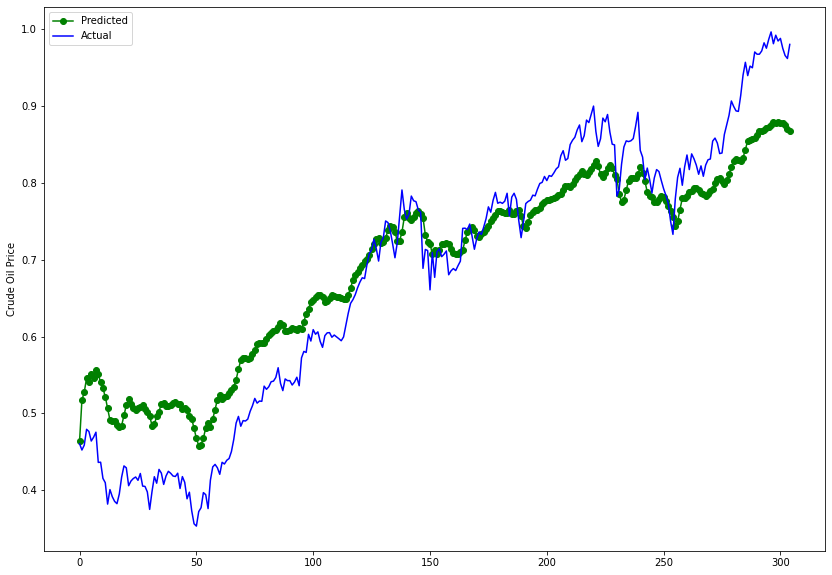

In [36]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Crude Oil Price')
plt.legend()

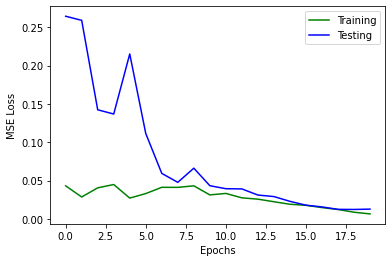

In [37]:
plt.plot(oil_train_mse, color="g", label="Training")
plt.plot(oil_test_mse, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

### (2) Running the model with L1 loss

In [38]:
lr = 0.001
rnn_oil2, oil_train_l1, oil_test_l1, predictions, values = train(train_loader, test_loader, lr, model_type="RNN", loss_func="l1")

C:\Users\goodu\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.15253506542036407
Total Testing MSELoss: 0.5361714363098145
Total Time Elapsed: 0.18860509999999664 seconds

Epoch 2/20 Done, Total Training Loss: 0.23091618951998258
Total Testing MSELoss: 0.27191686630249023
Total Time Elapsed: 0.1729939000000016 seconds

Epoch 3/20 Done, Total Training Loss: 0.16595549459912276
Total Testing MSELoss: 0.3860890865325928
Total Time Elapsed: 0.17169270000000125 seconds

Epoch 4/20 Done, Total Training Loss: 0.1555431369986189
Total Testing MSELoss: 0.4362962245941162
Total Time Elapsed: 0.16795460000000162 seconds

Epoch 5/20 Done, Total Training Loss: 0.16758865686623672
Total Testing MSELoss: 0.4431483745574951
Total Time Elapsed: 0.17804250000000366 seconds

Epoch 6/20 Done, Total Training Loss: 0.15889614898907511
Total Testing MSELoss: 0.39939188957214355
Total Time Elapsed: 0.17166050000000155 seconds

Epoch 7/20 Done, Total Training Loss: 0.15861874921737532
Total Testing MSE

In [39]:
loss_df['oil_train_l1'] = oil_train_l1
loss_df['oil_test_l1'] = oil_test_l1
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1,art1_train_mse,art1_test_mse,art1_train_l1,art1_test_l1,oil_train_mse,oil_test_mse,oil_train_l1,oil_test_l1
0,0.002426,0.167729,0.031228,0.475429,0.066847,0.004065,0.203694,0.150436,0.043167,0.264449,0.152535,0.536171
1,0.043995,0.336275,0.200716,0.698865,0.032104,0.002414,0.143381,0.137284,0.028633,0.259106,0.230916,0.271917
2,0.026599,0.296290,0.118361,0.599609,0.030061,0.022901,0.128498,0.102974,0.040555,0.142395,0.165955,0.386089
3,0.020329,0.244788,0.149733,0.624499,0.025089,0.014456,0.102960,0.095740,0.044880,0.136867,0.155543,0.436296
4,0.013738,0.119347,0.095307,0.280390,0.018290,0.006390,0.081906,0.055474,0.027182,0.215241,0.167589,0.443148
5,0.008711,0.020885,0.188996,0.485819,0.008903,0.004835,0.052100,0.015769,0.033082,0.111445,0.158896,0.399392
6,0.002963,0.023003,0.120668,0.440419,0.003600,0.000036,0.033874,0.048768,0.041246,0.059385,0.158619,0.311194
7,0.000601,0.017921,0.072040,0.196013,0.001231,0.000092,0.030018,0.056063,0.041186,0.047758,0.139890,0.267855
8,0.000788,0.005088,0.060737,0.150038,0.000901,0.000163,0.029079,0.050303,0.043188,0.066211,0.163488,0.204545
9,0.000325,0.022094,0.045987,0.125508,0.000673,0.000264,0.026320,0.046991,0.031352,0.043338,0.156455,0.210630


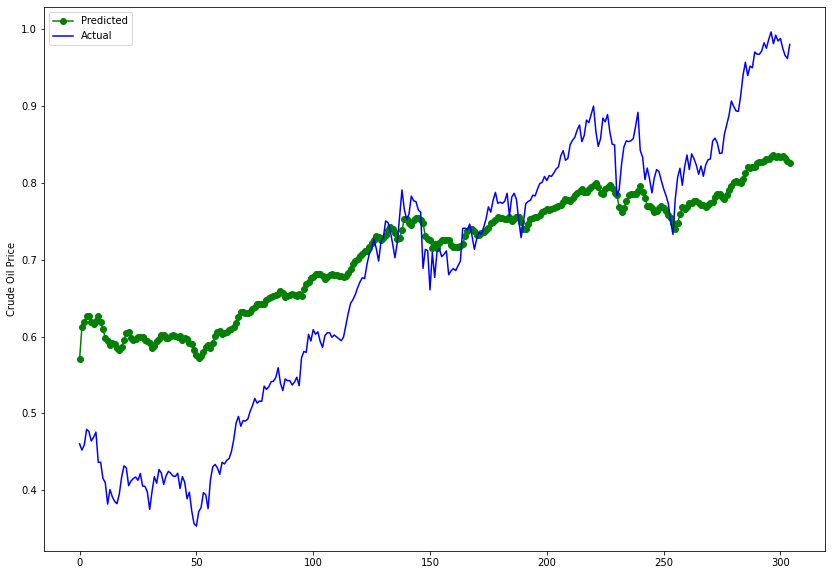

In [40]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Crude Oil Price')
plt.legend()

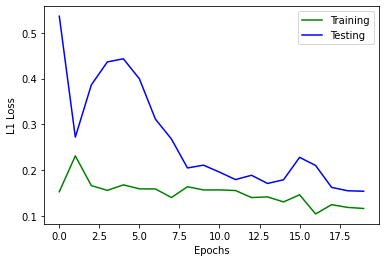

In [41]:
plt.plot(oil_train_l1, color="g", label="Training")
plt.plot(oil_test_l1, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()

## Bitcoin

In [42]:
coin_df = pd.read_csv(dataset_folder + "coin.csv")
coin_df['Date'] = pd.to_datetime(coin_df['Date'])
coin_df.set_index('Date', inplace=True)
coin_df = pd.DataFrame(coin_df['Close'])
coin_df.dropna(inplace=True)
coin_df

,Close
Date,
2013-04-29 23:59:59,144.539993
2013-04-30 23:59:59,139.000000
2013-05-01 23:59:59,116.989998
2013-05-02 23:59:59,105.209999
2013-05-03 23:59:59,97.750000
...,...
2021-07-02 23:59:59,33897.048590
2021-07-03 23:59:59,34668.548402
2021-07-04 23:59:59,35287.779766


In [43]:
#scaling the coin data
scaler = MinMaxScaler()
scaled_coin = scaler.fit_transform(coin_df.values)

train_x,train_y,test_x,test_y = split_data(scaled_coin, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (2389, 5, 1)
y_train.shape:  (2389, 1)
X_test.shape:  (597, 5, 1)
y_test.shape:  (597, 1)


In [44]:
batch_size = 64
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

### (1) Running the model with MSE loss

In [45]:
lr = 0.001
rnn_coin, coin_train_mse, coin_test_mse, predictions, values = train(train_loader, test_loader, lr, model_type="RNN")

Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.0024826889869448655


C:\Users\goodu\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Total Testing MSELoss: 0.13393248617649078
Total Time Elapsed: 0.28588349999999707 seconds

Epoch 2/20 Done, Total Training Loss: 0.0041825211524555185
Total Testing MSELoss: 0.14627186954021454
Total Time Elapsed: 0.281661899999996 seconds

Epoch 3/20 Done, Total Training Loss: 0.004127914486260223
Total Testing MSELoss: 0.15236340463161469
Total Time Elapsed: 0.29203580000000073 seconds

Epoch 4/20 Done, Total Training Loss: 0.004023097524291311
Total Testing MSELoss: 0.134090855717659
Total Time Elapsed: 0.3500951000000043 seconds

Epoch 5/20 Done, Total Training Loss: 0.005363702458231962
Total Testing MSELoss: 0.13561026751995087
Total Time Elapsed: 0.2833910999999958 seconds

Epoch 6/20 Done, Total Training Loss: 0.0032917114338340834
Total Testing MSELoss: 0.1475248634815216
Total Time Elapsed: 0.29251310000000075 seconds

Epoch 7/20 Done, Total Training Loss: 0.0055656024119389875
Total Testing MSELoss: 0.19838230311870575
Total Time Elapsed: 0.28663219999999967 seconds

Epoch 

In [46]:
loss_df['coin_train_mse'] = coin_train_mse
loss_df['coin_test_mse'] = coin_test_mse
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1,art1_train_mse,art1_test_mse,art1_train_l1,art1_test_l1,oil_train_mse,oil_test_mse,oil_train_l1,oil_test_l1,coin_train_mse,coin_test_mse
0,0.002426,0.167729,0.031228,0.475429,0.066847,0.004065,0.203694,0.150436,0.043167,0.264449,0.152535,0.536171,0.002483,0.133932
1,0.043995,0.336275,0.200716,0.698865,0.032104,0.002414,0.143381,0.137284,0.028633,0.259106,0.230916,0.271917,0.004183,0.146272
2,0.026599,0.296290,0.118361,0.599609,0.030061,0.022901,0.128498,0.102974,0.040555,0.142395,0.165955,0.386089,0.004128,0.152363
3,0.020329,0.244788,0.149733,0.624499,0.025089,0.014456,0.102960,0.095740,0.044880,0.136867,0.155543,0.436296,0.004023,0.134091
4,0.013738,0.119347,0.095307,0.280390,0.018290,0.006390,0.081906,0.055474,0.027182,0.215241,0.167589,0.443148,0.005364,0.135610
5,0.008711,0.020885,0.188996,0.485819,0.008903,0.004835,0.052100,0.015769,0.033082,0.111445,0.158896,0.399392,0.003292,0.147525
6,0.002963,0.023003,0.120668,0.440419,0.003600,0.000036,0.033874,0.048768,0.041246,0.059385,0.158619,0.311194,0.005566,0.198382
7,0.000601,0.017921,0.072040,0.196013,0.001231,0.000092,0.030018,0.056063,0.041186,0.047758,0.139890,0.267855,0.003629,0.181175
8,0.000788,0.005088,0.060737,0.150038,0.000901,0.000163,0.029079,0.050303,0.043188,0.066211,0.163488,0.204545,0.003856,0.173908
9,0.000325,0.022094,0.045987,0.125508,0.000673,0.000264,0.026320,0.046991,0.031352,0.043338,0.156455,0.210630,0.003498,0.165199


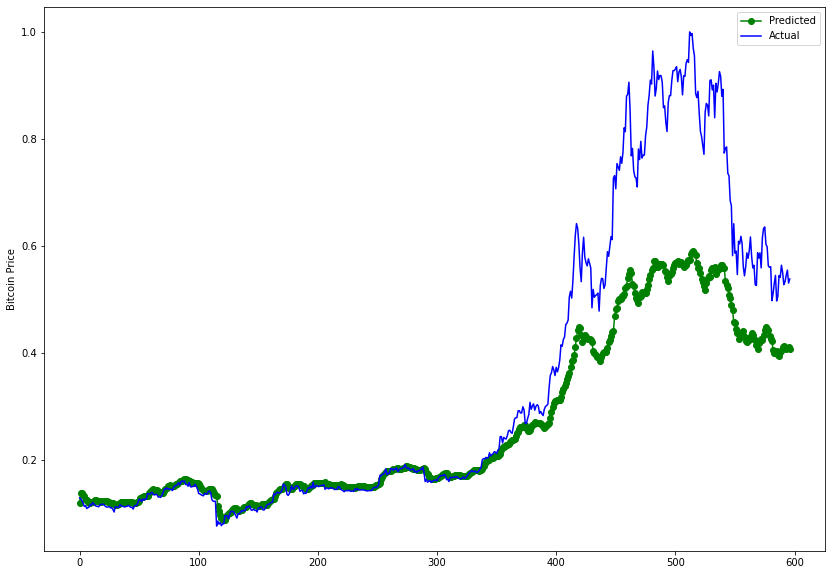

In [47]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Bitcoin Price')
plt.legend()

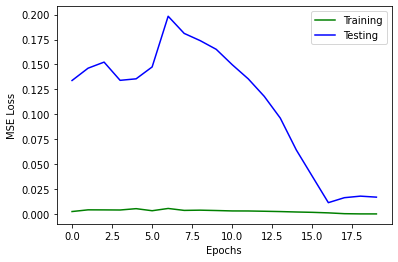

In [48]:
plt.plot(coin_train_mse, color="g", label="Training")
plt.plot(coin_test_mse, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

### (2) Running the model with L1 loss

In [49]:
lr = 0.001
rnn_coin2, coin_train_l1, coin_test_l1, predictions, values = train(train_loader, test_loader, lr, model_type="RNN", loss_func = "l1")

C:\Users\goodu\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.04682756677219594
Total Testing MSELoss: 0.43849730491638184
Total Time Elapsed: 0.28905590000000103 seconds

Epoch 2/20 Done, Total Training Loss: 0.043391477958475415
Total Testing MSELoss: 0.42188090085983276
Total Time Elapsed: 0.29860240000000005 seconds

Epoch 3/20 Done, Total Training Loss: 0.04683326331999253
Total Testing MSELoss: 0.3909488022327423
Total Time Elapsed: 0.3322552999999999 seconds

Epoch 4/20 Done, Total Training Loss: 0.058568314567359316
Total Testing MSELoss: 0.38380905985832214
Total Time Elapsed: 0.29451480000000174 seconds

Epoch 5/20 Done, Total Training Loss: 0.06277349514484003
Total Testing MSELoss: 0.41748014092445374
Total Time Elapsed: 0.29628749999999826 seconds

Epoch 6/20 Done, Total Training Loss: 0.043487360480719724
Total Testing MSELoss: 0.3709896206855774
Total Time Elapsed: 0.2970479000000026 seconds

Epoch 7/20 Done, Total Training Loss: 0.04215455312923704
Total Testin

In [50]:
loss_df['coin_train_l1'] = coin_train_l1
loss_df['coin_test_l1'] = coin_test_l1
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1,art1_train_mse,art1_test_mse,art1_train_l1,art1_test_l1,oil_train_mse,oil_test_mse,oil_train_l1,oil_test_l1,coin_train_mse,coin_test_mse,coin_train_l1,coin_test_l1
0,0.002426,0.167729,0.031228,0.475429,0.066847,0.004065,0.203694,0.150436,0.043167,0.264449,0.152535,0.536171,0.002483,0.133932,0.046828,0.438497
1,0.043995,0.336275,0.200716,0.698865,0.032104,0.002414,0.143381,0.137284,0.028633,0.259106,0.230916,0.271917,0.004183,0.146272,0.043391,0.421881
2,0.026599,0.296290,0.118361,0.599609,0.030061,0.022901,0.128498,0.102974,0.040555,0.142395,0.165955,0.386089,0.004128,0.152363,0.046833,0.390949
3,0.020329,0.244788,0.149733,0.624499,0.025089,0.014456,0.102960,0.095740,0.044880,0.136867,0.155543,0.436296,0.004023,0.134091,0.058568,0.383809
4,0.013738,0.119347,0.095307,0.280390,0.018290,0.006390,0.081906,0.055474,0.027182,0.215241,0.167589,0.443148,0.005364,0.135610,0.062773,0.417480
5,0.008711,0.020885,0.188996,0.485819,0.008903,0.004835,0.052100,0.015769,0.033082,0.111445,0.158896,0.399392,0.003292,0.147525,0.043487,0.370990
6,0.002963,0.023003,0.120668,0.440419,0.003600,0.000036,0.033874,0.048768,0.041246,0.059385,0.158619,0.311194,0.005566,0.198382,0.042155,0.365908
7,0.000601,0.017921,0.072040,0.196013,0.001231,0.000092,0.030018,0.056063,0.041186,0.047758,0.139890,0.267855,0.003629,0.181175,0.056895,0.386217
8,0.000788,0.005088,0.060737,0.150038,0.000901,0.000163,0.029079,0.050303,0.043188,0.066211,0.163488,0.204545,0.003856,0.173908,0.053867,0.393851
9,0.000325,0.022094,0.045987,0.125508,0.000673,0.000264,0.026320,0.046991,0.031352,0.043338,0.156455,0.210630,0.003498,0.165199,0.053481,0.393910


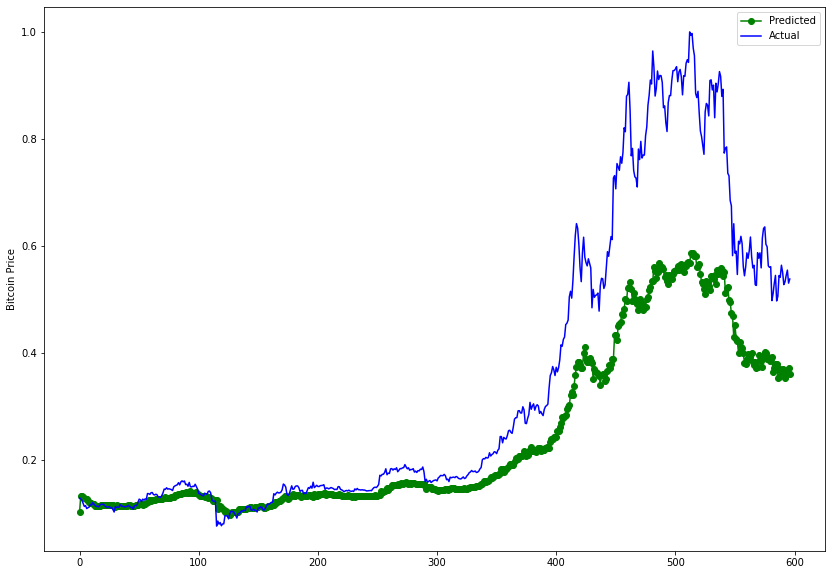

In [51]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Bitcoin Price')
plt.legend()

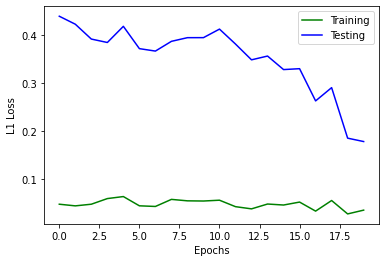

In [52]:
plt.plot(coin_train_l1, color="g", label="Training")
plt.plot(coin_test_l1, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()

## S&P500

In [53]:
sp_df = pd.read_csv(dataset_folder + "sp500.csv")
sp_df['Date'] = pd.to_datetime(sp_df['Date'])
sp_df.set_index('Date', inplace=True)
sp_df = pd.DataFrame(sp_df['SP500'])
sp_df.dropna(inplace=True)
sp_df

,SP500
Date,
1871-01-01,4.44
1871-02-01,4.50
1871-03-01,4.61
1871-04-01,4.74
1871-05-01,4.86
...,...
2017-12-01,2664.34
2018-01-01,2789.80
2018-02-01,2705.16


In [54]:
#scaling the s&p data
scaler = MinMaxScaler()
scaled_sp = scaler.fit_transform(sp_df.values)

train_x,train_y,test_x,test_y = split_data(scaled_sp, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (1410, 5, 1)
y_train.shape:  (1410, 1)
X_test.shape:  (353, 5, 1)
y_test.shape:  (353, 1)


In [55]:
batch_size = 32
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

### (1) Running the model with MSE loss

In [56]:
lr = 0.001
rnn_sp, sp_train_mse, sp_test_mse, predictions, values = train(train_loader, test_loader, lr, EPOCHS=50, model_type="RNN")

Starting Training of RNN model
Epoch 1/50 Done, Total Training Loss: 0.0011857623979846142


C:\Users\goodu\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Total Testing MSELoss: 0.7836672067642212
Total Time Elapsed: 0.20633759999999768 seconds

Epoch 2/50 Done, Total Training Loss: 0.0005745806680340335
Total Testing MSELoss: 0.7861294746398926
Total Time Elapsed: 0.22548229999999592 seconds

Epoch 3/50 Done, Total Training Loss: 0.0004492629615991849
Total Testing MSELoss: 0.7071332931518555
Total Time Elapsed: 0.19645839999999737 seconds

Epoch 4/50 Done, Total Training Loss: 0.00047113324211781304
Total Testing MSELoss: 0.7636271119117737
Total Time Elapsed: 0.20747489999999402 seconds

Epoch 5/50 Done, Total Training Loss: 0.0004987126448993836
Total Testing MSELoss: 0.7619083523750305
Total Time Elapsed: 0.20051720000000728 seconds

Epoch 6/50 Done, Total Training Loss: 0.0005101129343752963
Total Testing MSELoss: 0.73939448595047
Total Time Elapsed: 0.20085919999999646 seconds

Epoch 7/50 Done, Total Training Loss: 0.0004152860741803786
Total Testing MSELoss: 0.7234549522399902
Total Time Elapsed: 0.2056146000000041 seconds

Epoch

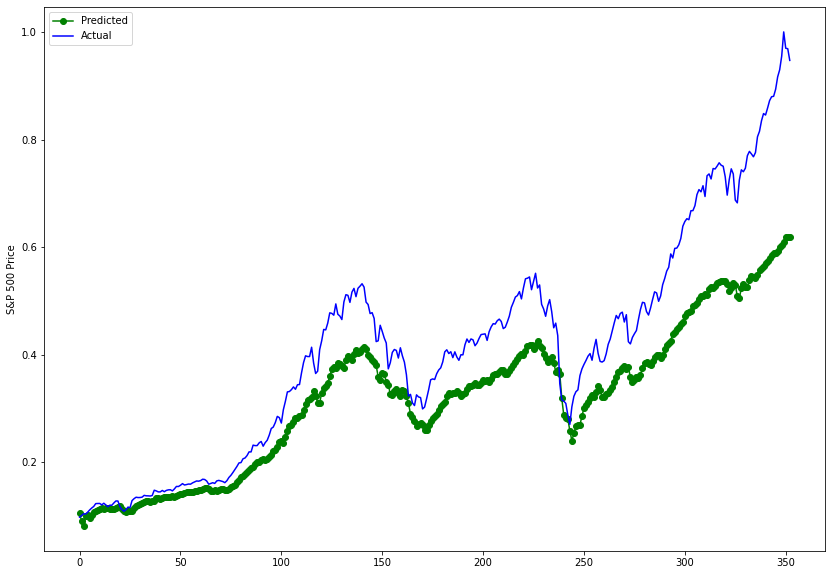

In [57]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('S&P 500 Price')
plt.legend()

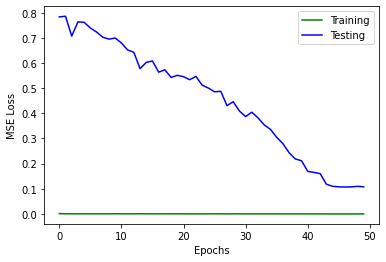

In [58]:
plt.plot(sp_train_mse, color="g", label="Training")
plt.plot(sp_test_mse, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

### (2) Running the model with L1 loss

In [59]:
lr = 0.001
rnn_sp2, sp_train_l1, sp_test_l1, predictions, values = train(train_loader, test_loader, lr, EPOCHS=50, model_type="RNN", loss_func = "l1")

C:\Users\goodu\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Starting Training of RNN model
Epoch 1/50 Done, Total Training Loss: 0.010450814522548833
Total Testing MSELoss: 0.8566120862960815
Total Time Elapsed: 0.23712550000000476 seconds

Epoch 2/50 Done, Total Training Loss: 0.014358062076181259
Total Testing MSELoss: 0.8497560024261475
Total Time Elapsed: 0.2709640000000064 seconds

Epoch 3/50 Done, Total Training Loss: 0.012218868136353029
Total Testing MSELoss: 0.854621946811676
Total Time Elapsed: 0.2133010000000013 seconds

Epoch 4/50 Done, Total Training Loss: 0.010507901564282789
Total Testing MSELoss: 0.843531608581543
Total Time Elapsed: 0.2180879999999945 seconds

Epoch 5/50 Done, Total Training Loss: 0.013846561706900089
Total Testing MSELoss: 0.8300837278366089
Total Time Elapsed: 0.23438749999999686 seconds

Epoch 6/50 Done, Total Training Loss: 0.015523291650672698
Total Testing MSELoss: 0.8067357540130615
Total Time Elapsed: 0.2502785000000074 seconds

Epoch 7/50 Done, Total Training Loss: 0.015063129381319
Total Testing MSELo

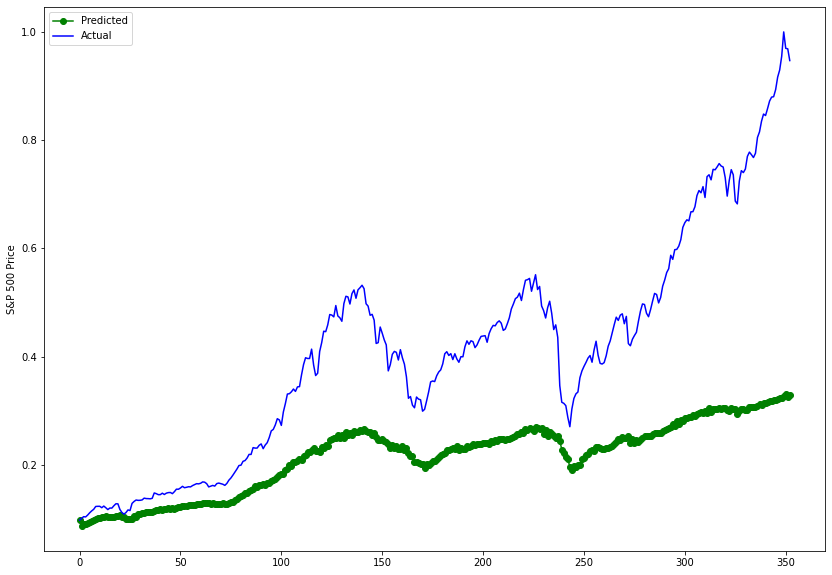

In [60]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('S&P 500 Price')
plt.legend()

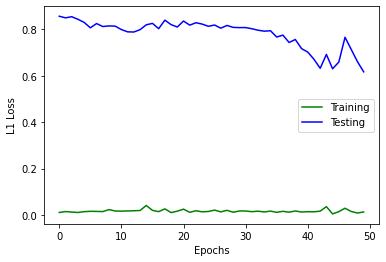

In [61]:
plt.plot(sp_train_l1, color="g", label="Training")
plt.plot(sp_test_l1, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()

## Artificial Data 2

In [62]:
art2_df = pd.read_csv(dataset_folder + "Artificial_trend1.csv")
art2_df
art2_df['date'] = pd.to_datetime(art2_df['date'])
art2_df.set_index('date', inplace=True)
art2_df.dropna(inplace=True)
art2_df

,trend
date,
2000-07-01,-0.030415
2000-07-02,-0.025551
2000-07-03,-0.029866
2000-07-04,-0.034355
2000-07-05,-0.028927
...,...
2020-06-28,0.044721
2020-06-29,0.046374
2020-06-30,0.048462


In [63]:
#scaling the sencond artificial dataset
scaler = MinMaxScaler()
scaled_art2 = scaler.fit_transform(art2_df.values)

train_x,train_y,test_x,test_y = split_data(scaled_art2, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (5842, 5, 1)
y_train.shape:  (5842, 1)
X_test.shape:  (1460, 5, 1)
y_test.shape:  (1460, 1)


In [64]:
batch_size = 64
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

### (1) Running with MSE

In [65]:
lr = 0.001
rnn_art2, art2_train_mse, art2_test_mse, predictions, values = train(train_loader, test_loader, lr, model_type="RNN")

Starting Training of RNN model


C:\Users\goodu\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/20 Done, Total Training Loss: 0.05313817253988748
Total Testing MSELoss: 0.16203691065311432
Total Time Elapsed: 0.7191812000000084 seconds

Epoch 2/20 Done, Total Training Loss: 0.02757794214482931
Total Testing MSELoss: 0.1296912431716919
Total Time Elapsed: 0.7194368000000111 seconds

Epoch 3/20 Done, Total Training Loss: 0.017760985445200498
Total Testing MSELoss: 0.08177950978279114
Total Time Elapsed: 0.7109494000000041 seconds

Epoch 4/20 Done, Total Training Loss: 0.009766752471837758
Total Testing MSELoss: 0.043979961425065994
Total Time Elapsed: 0.7477443000000079 seconds

Epoch 5/20 Done, Total Training Loss: 0.0038994329835666895
Total Testing MSELoss: 0.006090028211474419
Total Time Elapsed: 0.7407254000000023 seconds

Epoch 6/20 Done, Total Training Loss: 0.001958222385907832
Total Testing MSELoss: 0.008557402528822422
Total Time Elapsed: 0.7256386999999904 seconds

Epoch 7/20 Done, Total Training Loss: 0.001380660385820902
Total Testing MSELoss: 0.005782276391983

In [66]:
loss_df['art2_train_mse'] = art2_train_mse
loss_df['art2_test_mse'] = art2_test_mse
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1,art1_train_mse,art1_test_mse,art1_train_l1,art1_test_l1,oil_train_mse,oil_test_mse,oil_train_l1,oil_test_l1,coin_train_mse,coin_test_mse,coin_train_l1,coin_test_l1,art2_train_mse,art2_test_mse
0,0.002426,0.167729,0.031228,0.475429,0.066847,0.004065,0.203694,0.150436,0.043167,0.264449,0.152535,0.536171,0.002483,0.133932,0.046828,0.438497,0.053138,0.162037
1,0.043995,0.336275,0.200716,0.698865,0.032104,0.002414,0.143381,0.137284,0.028633,0.259106,0.230916,0.271917,0.004183,0.146272,0.043391,0.421881,0.027578,0.129691
2,0.026599,0.296290,0.118361,0.599609,0.030061,0.022901,0.128498,0.102974,0.040555,0.142395,0.165955,0.386089,0.004128,0.152363,0.046833,0.390949,0.017761,0.081780
3,0.020329,0.244788,0.149733,0.624499,0.025089,0.014456,0.102960,0.095740,0.044880,0.136867,0.155543,0.436296,0.004023,0.134091,0.058568,0.383809,0.009767,0.043980
4,0.013738,0.119347,0.095307,0.280390,0.018290,0.006390,0.081906,0.055474,0.027182,0.215241,0.167589,0.443148,0.005364,0.135610,0.062773,0.417480,0.003899,0.006090
5,0.008711,0.020885,0.188996,0.485819,0.008903,0.004835,0.052100,0.015769,0.033082,0.111445,0.158896,0.399392,0.003292,0.147525,0.043487,0.370990,0.001958,0.008557
6,0.002963,0.023003,0.120668,0.440419,0.003600,0.000036,0.033874,0.048768,0.041246,0.059385,0.158619,0.311194,0.005566,0.198382,0.042155,0.365908,0.001381,0.005782
7,0.000601,0.017921,0.072040,0.196013,0.001231,0.000092,0.030018,0.056063,0.041186,0.047758,0.139890,0.267855,0.003629,0.181175,0.056895,0.386217,0.000966,0.003188
8,0.000788,0.005088,0.060737,0.150038,0.000901,0.000163,0.029079,0.050303,0.043188,0.066211,0.163488,0.204545,0.003856,0.173908,0.053867,0.393851,0.000715,0.002577
9,0.000325,0.022094,0.045987,0.125508,0.000673,0.000264,0.026320,0.046991,0.031352,0.043338,0.156455,0.210630,0.003498,0.165199,0.053481,0.393910,0.000622,0.002452


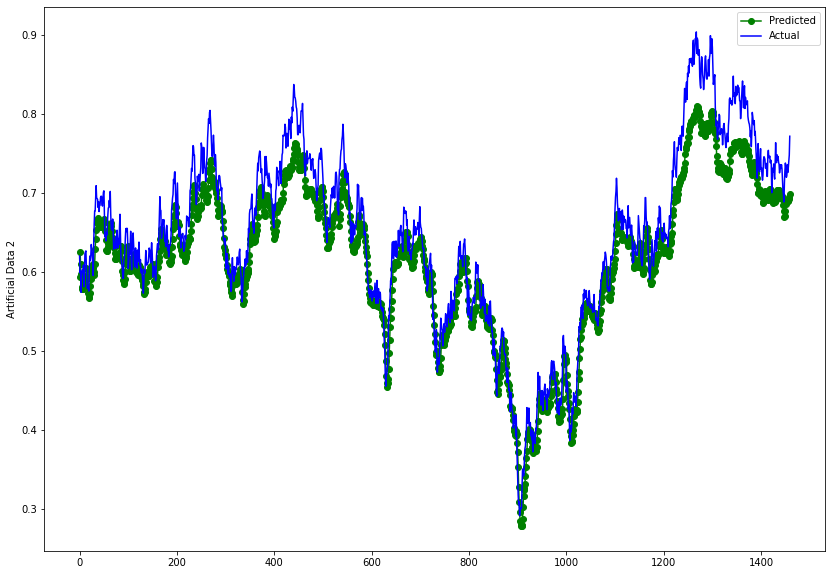

In [67]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Artificial Data 2')
plt.legend()

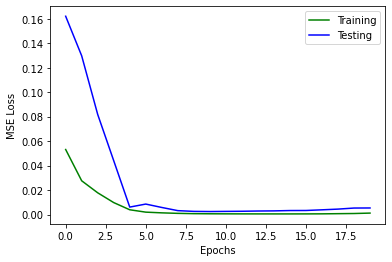

In [68]:
plt.plot(art2_train_mse, color="g", label="Training")
plt.plot(art2_test_mse, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

### (2) Running with L1 Loss

In [69]:
lr = 0.001
rnn_art2_2, art2_train_l1, art2_test_l1, predictions, values = train(train_loader, test_loader, lr, model_type="RNN", loss_func = "l1")

C:\Users\goodu\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.19789503987592
Total Testing MSELoss: 0.5159772634506226
Total Time Elapsed: 0.7036898000000065 seconds

Epoch 2/20 Done, Total Training Loss: 0.1628283475126539
Total Testing MSELoss: 0.45843514800071716
Total Time Elapsed: 0.6769551999999948 seconds

Epoch 3/20 Done, Total Training Loss: 0.13861013521123064
Total Testing MSELoss: 0.4141343832015991
Total Time Elapsed: 0.6916059999999931 seconds

Epoch 4/20 Done, Total Training Loss: 0.12268389528105547
Total Testing MSELoss: 0.16984307765960693
Total Time Elapsed: 0.6988134000000059 seconds

Epoch 5/20 Done, Total Training Loss: 0.09208625030018143
Total Testing MSELoss: 0.26751476526260376
Total Time Elapsed: 0.7080762000000078 seconds

Epoch 6/20 Done, Total Training Loss: 0.06953559684884417
Total Testing MSELoss: 0.1913946270942688
Total Time Elapsed: 0.6726850999999954 seconds

Epoch 7/20 Done, Total Training Loss: 0.0397964568685863
Total Testing MSELoss: 0.

In [70]:
loss_df['art2_train_l1'] = art2_train_l1
loss_df['art2_test_l1'] = art2_test_l1
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1,art1_train_mse,art1_test_mse,art1_train_l1,art1_test_l1,oil_train_mse,oil_test_mse,oil_train_l1,oil_test_l1,coin_train_mse,coin_test_mse,coin_train_l1,coin_test_l1,art2_train_mse,art2_test_mse,art2_train_l1,art2_test_l1
0,0.002426,0.167729,0.031228,0.475429,0.066847,0.004065,0.203694,0.150436,0.043167,0.264449,0.152535,0.536171,0.002483,0.133932,0.046828,0.438497,0.053138,0.162037,0.197895,0.515977
1,0.043995,0.336275,0.200716,0.698865,0.032104,0.002414,0.143381,0.137284,0.028633,0.259106,0.230916,0.271917,0.004183,0.146272,0.043391,0.421881,0.027578,0.129691,0.162828,0.458435
2,0.026599,0.296290,0.118361,0.599609,0.030061,0.022901,0.128498,0.102974,0.040555,0.142395,0.165955,0.386089,0.004128,0.152363,0.046833,0.390949,0.017761,0.081780,0.138610,0.414134
3,0.020329,0.244788,0.149733,0.624499,0.025089,0.014456,0.102960,0.095740,0.044880,0.136867,0.155543,0.436296,0.004023,0.134091,0.058568,0.383809,0.009767,0.043980,0.122684,0.169843
4,0.013738,0.119347,0.095307,0.280390,0.018290,0.006390,0.081906,0.055474,0.027182,0.215241,0.167589,0.443148,0.005364,0.135610,0.062773,0.417480,0.003899,0.006090,0.092086,0.267515
5,0.008711,0.020885,0.188996,0.485819,0.008903,0.004835,0.052100,0.015769,0.033082,0.111445,0.158896,0.399392,0.003292,0.147525,0.043487,0.370990,0.001958,0.008557,0.069536,0.191395
6,0.002963,0.023003,0.120668,0.440419,0.003600,0.000036,0.033874,0.048768,0.041246,0.059385,0.158619,0.311194,0.005566,0.198382,0.042155,0.365908,0.001381,0.005782,0.039796,0.107174
7,0.000601,0.017921,0.072040,0.196013,0.001231,0.000092,0.030018,0.056063,0.041186,0.047758,0.139890,0.267855,0.003629,0.181175,0.056895,0.386217,0.000966,0.003188,0.032335,0.107704
8,0.000788,0.005088,0.060737,0.150038,0.000901,0.000163,0.029079,0.050303,0.043188,0.066211,0.163488,0.204545,0.003856,0.173908,0.053867,0.393851,0.000715,0.002577,0.032843,0.059968
9,0.000325,0.022094,0.045987,0.125508,0.000673,0.000264,0.026320,0.046991,0.031352,0.043338,0.156455,0.210630,0.003498,0.165199,0.053481,0.393910,0.000622,0.002452,0.020283,0.065347


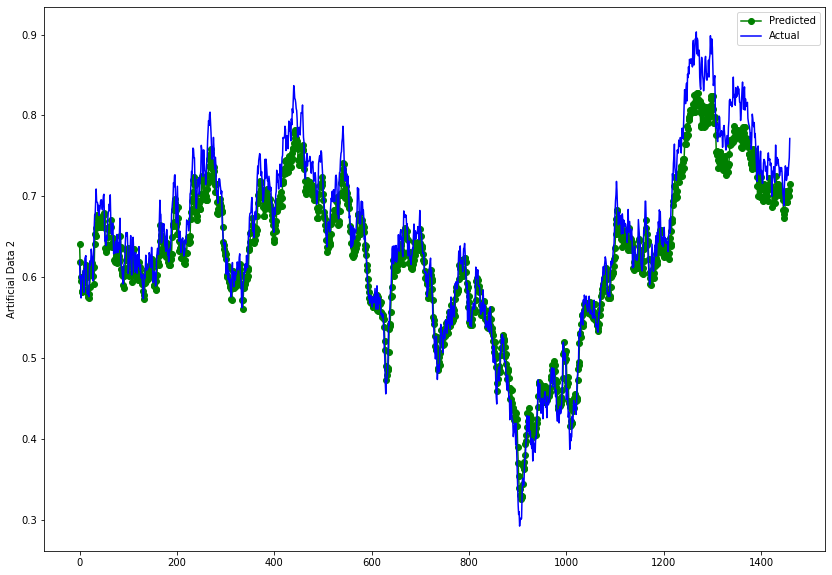

In [71]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Artificial Data 2')
plt.legend()

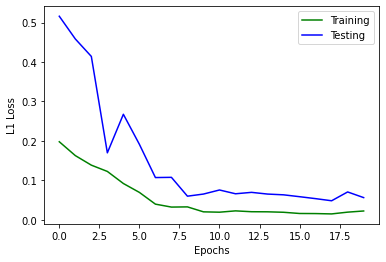

In [72]:
plt.plot(art2_train_l1, color="g", label="Training")
plt.plot(art2_test_l1, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()

## 